In [77]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt

The objective of this practical work is to implement the simple camera calibration method we saw in class. To do that, you will need a several pictures of a calibration pattern, which is chosen here to be a chessboard. 

In the last part, you will furthermore compare you results with the ones of openCV calibration function.

# Part I: load data

First, you have to load several calibration images, which is done in the following cell. The images are provided with this notebook.

**Question:** how many images do you need to calibrate the camera?

**Answer:** To calibrate the camera, we need at least 3 images.
In fact we have to use 3 homographies because P has 11 dof. Each homography gives us 4 equations, so we need at least 3 homographies to get 12 equations.

**Fill** the gaps in the following cell to enter the world coordinates of the corners in the chessboard.

**Explain** why do you have to remove one of the world frame coordinate?

**Answer:** By removing one of the world frame coordinates (here it is Z), the projection becomes an homography.

In [78]:
# First, you have to set the world coordinates of the corners in the chessboard, which we will call objpoints. We will consider that the cells of the chessboard have a length side of 1.
# Please note that you only have to take the inner corner of the chessbord, which correspond to full squares. Therefore, we will consider that there 7 row corners and 6 column corners.

objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = [[i,j] for i in range(6) for j in range(7)] # 3D coordinates in real world space. A np.array, each column corresponding to the 3D Euclidiean coordinates - the last coordinate is always chosen to be 0)
objpoints = objp[:,:2]  # Remove a useless dimension in the world coordinates. Explain.

Now, **fill** the code below by entering the path of the folder in which you saved the image.

**Question:** What is the code below doing?

**Answer:** The code below is loading the images from the specified folder and storing them in a list called "images". It also creates a list of object points (3D points in the world coordinate system) for the chessboard corners, which will be used for camera calibration. The object points are defined in a 3D space with Z=0, as the chessboard is flat.

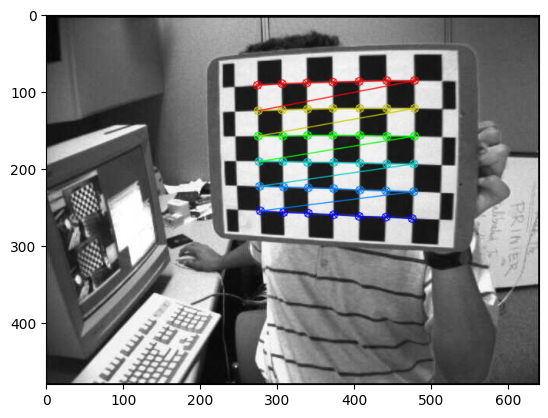

coucou


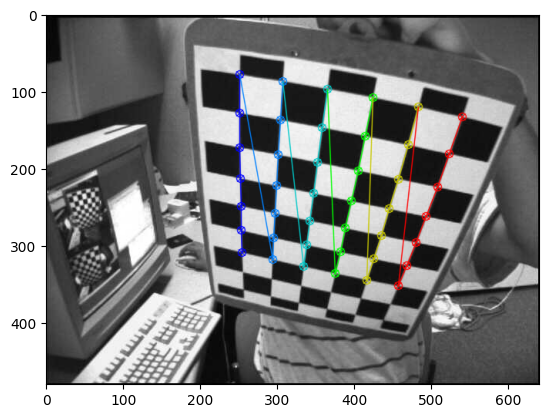

coucou


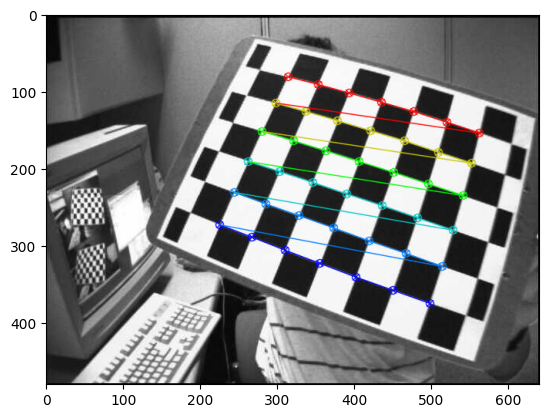

coucou


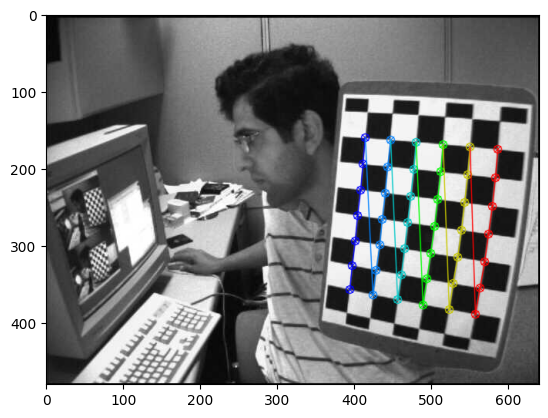

coucou


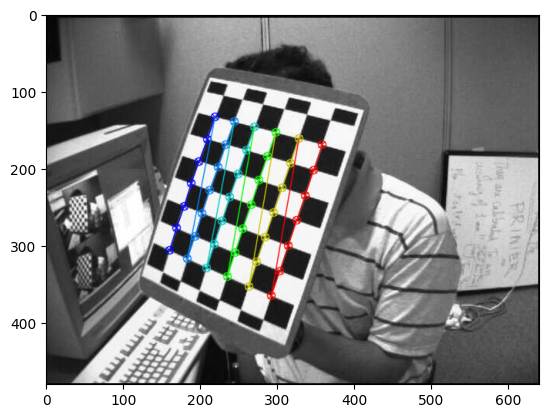

coucou


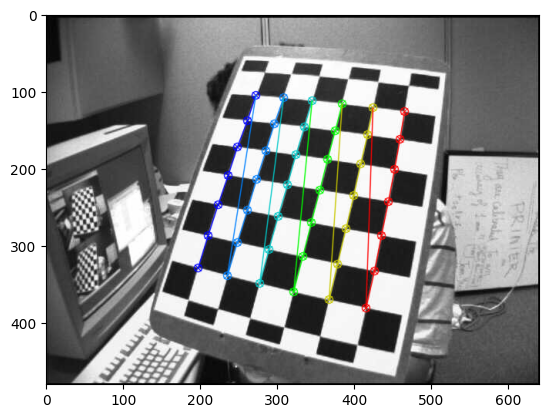

coucou


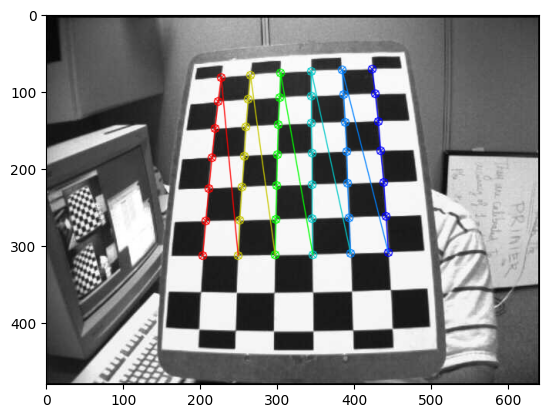

coucou


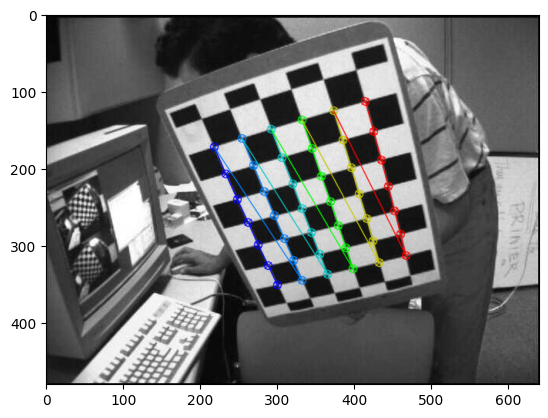

coucou


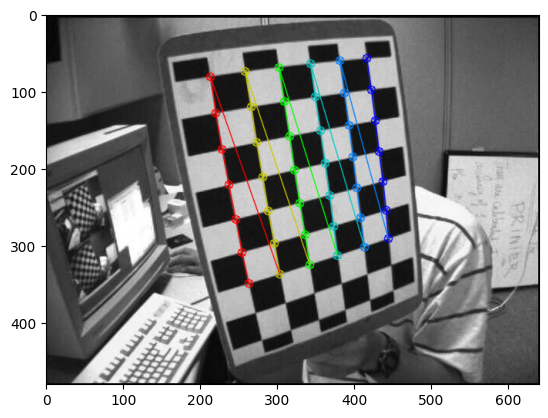

coucou


In [79]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
imgpoints = [] # 2D points in image plane. List (length = nb of images) of np.array, each of size = 2 (corresponding to the 2D Euclidiean coordinates - the coordinates might not be integers)
images = glob.glob('Chessboards/*.jpg') # To be filled.
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(np.squeeze(corners2))
        
        # Draw and display the corners
        cv.drawChessboardCorners(img, (7,6), corners2, ret)
        plt.imshow(img)
        plt.show()
        print('coucou')
        
        

# Part II: camera calibration

The objective of this part is to perform the camera calibration using the algorithm we saw in class.

**Question:** Recall what camera calibration is. What parameters are we looking for?

**Answer:** Camera calibration is the process of estimating the intrinsic and extrinsic parameters of a camera. The intrinsic parameters include the focal length, principal point, and distortion coefficients, while the extrinsic parameters describe the camera's position and orientation in the world coordinate system. The goal is to obtain a camera matrix that can accurately project 3D points in the world onto 2D points in the image.

1. Intrinsic parameters (5 dof):  
    * $f_x$, $f_y$ (focal lengths in pixels)  
    * $c_x$, $c_y$ (optical center)  
    * $s$ (skew coefficient)  

2. Extrinsic parameters for each image (6 dof per image):  
    * 3 for rotation  
    * 3 for translation  

**Question:** Recall the main principles of the calibration algorithm we saw in class. What are the main steps that need to be implemented?

**Answer:**     

1. **Acquire Multiple Calibration Images**  
   - Use a known calibration pattern (like a checkerboard).
   - Take at least **3 images** from different viewpoints.

2. **Detect 2D-3D Correspondences**  
   - Detect **corner points** in the image (2D).
   - Know the corresponding **points in the real world** (3D  with `Z = 0`).

3. **Estimate Homographies**
   - For each image, estimate the **homography `H`** between world and image points. (We usually use **RANSAC**)

4. **Set up Linear Constraints on the Intrinsics**
   - Use constraints:
     - $h_1^T K^{-T} K^{-1} h_2 = 0$
     - $h_1^T K^{-T} K^{-1} h_1 = h_2^T K^{-T} K^{-1} h_2$
   - Build a system $Vb = 0$ using multiple homographies where b is a vector made with $B_{i,j}$.

5. **Solve for Intrinsic Matrix `K`**
   - Use **SVD** to solve.
   - Recover `K` via **Cholesky decomposition** of $B = K^{-T}K^{-1}$.

6. **Compute Extrinsic Parameters for Each View**
   - Use:
     - $r_1 = \frac{1}{sc} K^{-1} h_1$
     - $r_2 = \frac{1}{sc} K^{-1} h_2$
     - $r_3 = r_1 \times r_2$
     - $t = \frac{1}{sc} K^{-1} h_3$

7. **Model and Estimate Lens Distortion**
   - Initialize distortion coefficients to 0.
   - Minimize **reprojection error** over all parameters:
     - $K, R_i, t_i, \kappa_1, \kappa_2, \kappa_3, \kappa_4, \kappa_5$

8. **Optionnalu**
   - $R$ might not be orthonormal due to noise. We can therefore, take the closest orthonormal matrix as $R$.

To compute the calibration matrix, we first be able to compute some homographies between images. As you have already done so in the previous practical work, some code is provided below.

**Question:** What is the name of the homography estimation algorithm implemented below?

**Answer:** It is the DLT (Direct Linear Transform) algorithm.

In [80]:
# Homography computation. See the previous pratical work for more details.
def svd_solve(A):
    """Solve a homogeneous least squares problem with the SVD
       method.

    Args:
       A: Matrix of constraints.
    Returns:
       The solution to the system.
    """
    U, S, V_t = np.linalg.svd(A)
    idx = np.argmin(S)

    least_squares_solution = V_t[idx]

    return least_squares_solution

def to_homogeneous(A):
    """Convert a stack of inhomogeneous vectors to a homogeneous 
       representation.
    """
    A = np.atleast_2d(A)

    N = A.shape[0]
    A_hom = np.hstack((A, np.ones((N,1))))

    return A_hom

def calculate_normalization_matrix(data):
    """Calculates zero-centered, sqrt(2) distance transformed
       matrix transform for data.

       Args:
          data: Nx2 stack of data points
        Returns:
          The normalization matrix
    """
    if data.ndim != 2 or data.shape[-1] != 2:
        raise ValueError('Dataset must be a collection of 2D points')

    x, y = data[:, 0], data[:, 1]

    N = data.shape[0]

    x_mean, y_mean = x.mean(), y.mean()
    x_var, y_var = x.var(), y.var()
    
    # Form rescaling matrix so that data points will lie
    # sqrt(2) from the origin on average.
    s_x, s_y = np.sqrt(2. / x_var), np.sqrt(2. / y_var)
    
    norm_matrix = np.array([[s_x,  0., -s_x * x_mean],
                            [ 0., s_y, -s_y * y_mean],
                            [ 0.,  0.,            1.]])

    return norm_matrix

def calculate_homography(model, data):
    """Perform linear least squares to calculate homography between planar 
       model and sensor data
    """
    N = model.shape[0]

    # Normalize data
    norm_matrix_model = calculate_normalization_matrix(model)
    norm_matrix_data  = calculate_normalization_matrix(data)

    model = to_homogeneous(model)
    data =  to_homogeneous(data)

    model_norm = np.dot(model, norm_matrix_model.T)
    data_norm = np.dot(data, norm_matrix_data.T)

    X, Y, x, y = model_norm[:,0], model_norm[:,1], data_norm[:,0], data_norm[:,1]
    
    # Mount homogeneous constraint matrix (See Burger pg. 11-13 for a derivation)
    A = np.zeros((N * 2, 9))

    x_component = np.zeros((N, 9))
    x_component[:, 0] = -X
    x_component[:, 1] = -Y
    x_component[:, 2] = -1.
    x_component[:, 6] =  x * X
    x_component[:, 7] =  x * Y
    x_component[:, 8] =  x

    y_component = np.zeros((N, 9))
    y_component[:, 3] = -X
    y_component[:, 4] = -Y
    y_component[:, 5] = -1.
    y_component[:, 6] =  y * X
    y_component[:, 7] =  y * Y
    y_component[:, 8] =  y

    # Note that all x-constraints precede all y-constraints for convenience of 
    # representation.
    A[:N] = x_component
    A[N:] = y_component

    # Solve homogeneous system
    h_norm = svd_solve(A)

    # Reconstitute normalized homography
    H_norm = h_norm.reshape((3,3))

    # Denormalize
    H = np.dot(np.dot(np.linalg.inv(norm_matrix_data), H_norm), norm_matrix_model)

    return H

In the following cell, compute the homographies for all the calibrations images in which you have extracted the corner coordinates. 

**Question:** what is the format of the homographies variable? Explain.

**Answer:** The homographies variable is a list of 3x3 matrices, where each matrix represents the homography between the world coordinates of the chessboard corners and the image coordinates in each calibration image. Each homography matrix is computed using the DLT algorithm based on the detected corner points in the images and their corresponding 3D world coordinates. The list contains one homography matrix for each calibration image.

In [81]:
# Finds the homography for each image
homographies = []
for iData in range(len(imgpoints)):
    H = calculate_homography(objpoints,imgpoints[iData])
    homographies.append(H)

In [82]:
homographies[0]

array([[ 1.19965768e+00,  1.62526832e+01, -2.66767945e+02],
       [ 2.03529845e+01, -1.27784529e+00, -1.48192973e+02],
       [ 2.96680863e-03, -8.40383527e-03, -5.59795950e-01]])

Now, let us start doing the calibration itself. To do that, as seen during the class, you will have to solve a linear system $\mathbf{Vb = 0}$. Recall how the $\mathbf{V}$ matrix is computed from the different homographies found previously.

**Answer:** 
To compute the matrix $\mathbf{V}$ used in the linear system $\mathbf{Vb = 0}$, we start from a set of homographies $H^{(i)} = [\mathbf{h}_1^{(i)}, \mathbf{h}_2^{(i)}, \mathbf{h}_3^{(i)}]$ estimated from $n$ calibration images.

Each homography provides two constraints on the intrinsic camera parameters through the relation:

- $\mathbf{h}_1^\top \mathbf{B} \mathbf{h}_2 = 0$
- $\mathbf{h}_1^\top \mathbf{B} \mathbf{h}_1 = \mathbf{h}_2^\top \mathbf{B} \mathbf{h}_2$

where $\mathbf{B} = \mathbf{K}^{-T} \mathbf{K}^{-1}$ is a symmetric matrix encoding the intrinsics. It can be parameterized with a 6-vector $\mathbf{b}$:

$$
\mathbf{b} = [B_{11}, B_{12}, B_{22}, B_{13}, B_{23}, B_{33}]^\top
$$

For each homography, define the vector $\mathbf{v}_{ij}$ as:

$$
\mathbf{v}_{ij} = \begin{bmatrix}
h_{i1} h_{j1} \\
h_{i1} h_{j2} + h_{i2} h_{j1} \\
h_{i2} h_{j2} \\
h_{i3} h_{j1} + h_{i1} h_{j3} \\
h_{i3} h_{j2} + h_{i2} h_{j3} \\
h_{i3} h_{j3}
\end{bmatrix}
$$

Then for each homography, we get two rows of $\mathbf{V}$:
- $\mathbf{v}_{12}^\top$
- $(\mathbf{v}_{11} - \mathbf{v}_{22})^\top$

Stacking these $2n$ rows (two per homography) results in a $2n \times 6$ matrix $\mathbf{V}$. We then solve the system $\mathbf{Vb = 0}$ using singular value decomposition (SVD), and recover the intrinsic parameters from the vector $\mathbf{b}$.


There are two constraints used for performing calibration: the orthogonality constraint and the normalization constraint. Both can be implemented using the $\mathbf{v}_{ij}$ matrix: $\mathbf{v}_{01}$ encodes the orthogonality constraints between $\mathbf{h}_0$ and $\mathbf{h}_1$, while the $\mathbf{v}_{00}$ and $\mathbf{v}_{11}$ encode the normalization constraint for $\mathbf{h}_0$ and $\mathbf{h}_1$. To write the constraints efficiently, code below the generation of $\mathbf{v}_{ij}$ (which will be later on used to implement the $\mathbf{V}$ matrix).

In [83]:
def generate_v_ij(H_stack, i, j):
    """Generate intrinsic ORTHOGONALITY constraints. 
    
    Input:
    - H_stack: a matrix nx3x3 matrix, containing the homographies for the n different images.
    - i: an index of a column of H
    - j: an index of a column of H
    
    Output:
    v_ij: a nx6 matrix containing the orthogonality constraints for all the n images
    """ 
    M = H_stack.shape[0]


    v_ij = np.zeros((M, 6))

    v_ij[:, 0] = H_stack[:,i,0]*H_stack[:,j,0]
    v_ij[:, 1] = H_stack[:,i,0]*H_stack[:,j,1]+H_stack[:,i,1]*H_stack[:,j,1] 
    v_ij[:, 2] = H_stack[:,i,1]*H_stack[:,j,1]
    v_ij[:, 3] = H_stack[:,i,2]*H_stack[:,j,0]+H_stack[:,i,0]*H_stack[:,j,2]
    v_ij[:, 4] = H_stack[:,i,2]*H_stack[:,j,1]+H_stack[:,i,1]*H_stack[:,j,2]
    v_ij[:, 5] = H_stack[:,i,2]*H_stack[:,j,2]

    return v_ij



Now, the generate_v_ij function can be used generate the full constraint matrix $\mathbf{V}$ and in turn find the intrinsic parameters.

**Question:** what are the intrinsic and the extrinsic parameters? What is distinguishing them?

**Answer:**

**Intrinsic Parameters**

The intrinsic parameters describe the internal characteristics of the camera:

- Focal length ($f_x$, $f_y$): Determines the zoom level in pixels.
- Principal point ($c_x$, $c_y$): The optical center of the image (in pixels).
- Skew coefficient ($s$): Describes the tilt of the pixels (often zero).
- Distortion coefficients ($k_1$, $k_2$, $p_1$, $p_2$): Correct for lens distortions.

**Extrinsic Parameters**

The extrinsic parameters define the position and orientation of the camera in 3D space:

- Rotation ($R$): A $3×3$ matrix describing the camera's orientation.
- Translation ($t$): A $3×1$ vector indicating the camera's position.


The difference between intrinsic and extrinsic parameters lies in their roles:
- Intrinsic parameters are specific to the camera and describe how 3D points are projected onto the image plane.
- Extrinsic parameters describe the camera's position and orientation in the world coordinate system, allowing us to relate 3D points in the world to their 2D projections in the image.

Fill the gaps in the function below to recover the instrinsics.

In [84]:
def recover_intrinsics(homographies):
    """Use computed homographies to calculate intrinsic matrix.
       Requires >= 3 homographies for a full 5-parameter intrinsic matrix.
    """
    M = len(homographies)

    # Stack homographies
    H_stack = np.zeros((M, 3, 3))
    for h, H in enumerate(homographies):
        H_stack[h] = H # H_stack, of size nx3x3 containing all the homographies for the n calibration images

    # Generate constraints
    
    v_00 = generate_v_ij(H_stack,0,0) # Normalization constraint
    v_01 = generate_v_ij(H_stack,0,1) # Orthogonality constraint
    v_11 = generate_v_ij(H_stack,1,1) # Normalization constraint

    
    # Generate the V matrix using v_01,v_00,v_11
    V = np.zeros((2 * M, 6))
    V[:M] = v_01 # Orthogonality constraint
    V[M:] = v_00-v_11 # Equality of norms constraint
    
    # Use SVD to solve the homogeneous system Vb = 0. You can directly the svd_solve function
    b = svd_solve(V)

    
    # Reshape the coefficients of b to transform them into the B symmetric matrix
    B0, B1, B2, B3, B4, B5 = b
    B = np.array([[B0, B1, B3],
                  [B1, B2, B4],
                  [B3, B4, B5]])
    
    
    # To find K from B, the explicit link between the B and K matrix is used. YOU DON'T NEED TO CHANGE ANYTHING UNTIL THE END OF THE FUNCTION
    # Form auxilliaries
    w = B0 * B2 * B5 - B1**2 * B5 - B0 * B4**2 + 2. * B1 * B3 * B4 - B2 * B3**2
    d = B0 * B2 - B1**2

    # Use Zhang's closed form solution for intrinsic parameters (Zhang, Appendix B, pg. 18)
    v0 = (B[0,1] * B[0,2] - B[0,0] * B[1,2]) / (B[0,0] * B[1,1] - B[0,1] * B[0,1])
    lambda_ = B[2,2] - (B[0,2] * B[0,2] + v0 * (B[0,1] * B[0,2] - B[0,0] * B[1,2])) / B[0,0]
    alpha = np.sqrt(lambda_ / B[0,0])
    beta = np.sqrt(lambda_ * B[0,0] / (B[0,0] * B[1,1] - B[0,1] * B[0,1]))
    gamma = -B[0,1] * alpha * alpha * beta / lambda_
    u0 = gamma * v0 / beta - B[0,2] * alpha * alpha / lambda_

    # Reconstitute intrinsic matrix
    K = np.array([[alpha, gamma, u0],
                  [   0.,  beta, v0],
                  [   0.,    0., 1.]])

    return K

**Question:** The above code use the closed form expression of Zhang for making the link between the $B$ and $K$ matrices. How would you have done otherwise?

**Answer:** 

K could be recovered using the Cholesky decomposition of B.
The Cholesky decomposition is given by:
$$B = L L^T$$
where L is a lower triangular matrix. Then K can be obtained as:
$$K = L^{-T}$$

Apply the recover_instrinsics function on the homographies you already computed. What $K$ matrix are you obtaining?

In [85]:
# Infer the calibration matrix (intrinsics) from the already found homographies
K = recover_intrinsics(homographies)

In [86]:
K

array([[ 3.78827983e-02, -4.95804791e-03, -8.37744019e-04],
       [ 0.00000000e+00,  3.49455146e-02, -2.23953565e-02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

# Part III - recover the extrinsics

Now, let us compute the extrinsics! Look at the code below and fill the gaps.

**Question:** what is the purpose of the reorthogonalize function and why is it useful?

**Answer:** The reothogonalize function ensures that a rotation matrix remains orthogonal. As we said before, due to noise, our estimate of $R$ might not be orthonotmal. Therefore we can replace $R$ by its colosest orthonormal matrix.

In [87]:
def to_homogeneous_3d(A):
    """Convert a stack of inhomogeneous vectors (without a Z component)
       to a homogeneous full-form representation.
    """
    if A.ndim != 2 or A.shape[-1] != 2:
        raise ValueError('Stacked vectors must be 2D inhomogeneous')

    N = A.shape[0]
    A_3d = np.hstack((A, np.zeros((N,1))))
    A_3d_hom = to_homogeneous(A_3d)

    return A_3d_hom

def reorthogonalize(R):
    """Determine least distance (Frobenius norm)rotation matrix 
       from a rotation matrix that has drifted away from orthogonality.

    Args:
       R: The matrix to reorthogonalize.
    Returns:
       The reorthogonalized matrix.
    """
    U, S, V_t = np.linalg.svd(R)
    new_R = np.dot(U, V_t)
    return new_R

def recover_extrinsics(H, K):
    """Use computed homography and intrinsic matrix to calculate
       corresponding extrinsic matrix

    Args:
       H: 3x3 homography matrix
       K: 3x3 intrinsic matrix
    Returns:
       3x4 extrinsic matrix
    """
	# Obtain column vectors from homography matrix
    h0, h1, h2 = H[:,0], H[:,1], H[:,2]
    # h0, h1, h2 = ..., ..., ...
    
    # Compute the inverse of the already computed calibration matrix
    K_inv = np.linalg.inv(K)

    # Form normalizer sc
    sc = np.linalg.norm(K_inv @ h0)
    lambda_ = 1. / sc
    
    # Compute r0, r1, and t from the homography. r2 can be derived
    # by an orthogonality constraint (np.cross)
    
    r0 = K_inv@h0*lambda_ 
    r1 = K_inv@h1*lambda_
    r2 = np.cross(r0,r1)
    t  = K_inv@h2*lambda_
    

    # Reconstitute the rotation component of the extrinsics and reorthogonalize
    R = np.vstack((r0, r1, r2)).T
    R = reorthogonalize(R)

    # Reconstitute full extrinsics
    E = np.hstack((R, t[:, np.newaxis]))

    return E

Apply the above function to each homography to recover the extrinsics for each image based on fixed intrinsics. In addition, the projection error is computed for each image so that you can check the result quality. Conclusions?

**Answer:** The projection error measures how good the estimated parameters are. The results are all relatuvely low and they have the same order of magnitude except for the second image. I do not have a clear explanation for that. It could be due to the fact that the chessboard was not flat or that the image was not well taken.

In [88]:
def to_inhomogeneous(A):
    """Convert a stack of homogeneous vectors to an inhomogeneous
       representation.
    """
    A = np.atleast_2d(A)

    N = A.shape[0]
    A /= A[:,-1][:, np.newaxis]
    A_inhom = A[:,:-1]

    return A_inhom


# Recover the extrinsics for each image based on fixed intrinsics
extrinsic_matrices = []
for h, H in enumerate(homographies):
    E = recover_extrinsics(H, K)
    extrinsic_matrices.append(E)
    
    # Look at the projection error
    # Form projection matrix
    P = K@E
    
    model_hom_3d = to_homogeneous_3d(objpoints)
    predicted = np.dot(model_hom_3d, P.T) #x = PX but this writing enables to do the computations for all the points in a single operation
    predicted = to_inhomogeneous(predicted)
    data = imgpoints[h]
    nonlinear_sse_decomp = np.sqrt(np.sum((predicted - data)**2))
    print(nonlinear_sse_decomp)

266.79428991160927
614.9078679007949
171.05434668261444
248.6695167582298
282.6068479750984
257.08241212826255
204.12480210766432
281.8525156057372
206.389145824315


In [89]:
print(extrinsic_matrices[2])

[[-3.83327344e-01  9.23612552e-01 -5.33900025e-06 -1.11941875e+01]
 [ 9.23612552e-01  3.83327344e-01 -2.67548867e-05 -8.24454692e+00]
 [-2.26645644e-05 -1.51870473e-05 -1.00000000e+00 -7.65997714e-04]]


# Part IV - distortion

In this last part, we look for the deviations to the linear model by computing the distortions of the camera. For finding the distortion parameters, we will look for a maximum likelihood estimation. Fill the code in the function below.

In [90]:
def calculate_lens_distortion(model, all_data, K, extrinsic_matrices):
    """Calculate least squares estimate of distortion coefficients.

    Args:
       model: Nx2 planar points in the world frame (objpoints)
       all_data: M-length list of Nx2 sensor frame correspondences (imgpoints)
       K: 3x3 intrinsics matrix
       exrinsic_matrices: M-length list of 3x4 extrinsic matrices
    Returns:
       Radial distortion coefficients [k0, k1]
    """
    M = len(all_data)
    N = model.shape[0]

    model = to_homogeneous_3d(model)

    u_c, v_c = K[0,2], K[1,2]

    # Form radius vector
    r = np.zeros(2 * M * N)
    for e, E in enumerate(extrinsic_matrices):
        normalized_projection = np.dot(model, E.T)
        normalized_projection = to_inhomogeneous(normalized_projection)

        x_normalized_proj, y_normalized_proj = normalized_projection[:, 0], normalized_projection[:, 1]
        
        r_i = x_normalized_proj**2+y_normalized_proj**2 # Compute the radius
        r[e*N:(e+1)*N] = r_i
    r[M*N:] = r[:M*N]

    # Form observation vector
    obs = np.zeros(2 * M * N)
    u_data, v_data = np.zeros(M * N), np.zeros(M * N)
    for d, data in enumerate(all_data):
        u_i, v_i = data[:, 0], data[:, 1]
        u_data[d*N:(d+1)*N] = u_i
        v_data[d*N:(d+1)*N] = v_i
    obs[:M*N] = u_data
    obs[M*N:] = v_data

    # Form prediction vector
    pred = np.zeros(2 * M * N)
    pred_centered = np.zeros(2 * M * N)
    u_pred, v_pred = np.zeros(M * N), np.zeros(M * N)
    for e, E in enumerate(extrinsic_matrices):
        P = K@E#Compute the projection matrix using K and E
        projection = model @ P.T#Project all the 3D points in model using P
        projection = to_inhomogeneous(projection)
        u_pred_i = projection[:, 0]
        v_pred_i = projection[:, 1]

        u_pred[e*N:(e+1)*N] = u_pred_i
        v_pred[e*N:(e+1)*N] = v_pred_i
    pred[:M*N] = u_pred
    pred[M*N:] = v_pred
    pred_centered[:M*N] = u_pred - u_c
    pred_centered[M*N:] = v_pred - v_c

    # Form distortion coefficient constraint matrix
    D = np.zeros((2 * M * N, 2))
    D[:, 0] = pred_centered * r**2
    D[:, 1] = pred_centered * r**4

    # Form values (difference between sensor observations and predictions)
    b = obs - pred

    # Use pseudoinverse technique to compute least squares solution for distortion coefficients
    D_inv = np.linalg.pinv(D)
    k = np.dot(D_inv, b)

    return k

**Question:** in the above function, what is the distortion model used?

**Answer:** It is the radial distortion model.

Launch the above code to find the distortion parameters and plot the undistorted images. How good do you find the results? Explain how they could be improved.

**Answer:** The results are good, but they could be improved by using more calibration images from different angles and distances. Additionally, using a more complex distortion model or optimizing the parameters further could lead to better undistortion results.

In [91]:
k = calculate_lens_distortion(objpoints, imgpoints, K, extrinsic_matrices)

In [92]:
print(k)

[-5.98407705e-53 -6.48611622e-36]


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x20ce87297d0>)

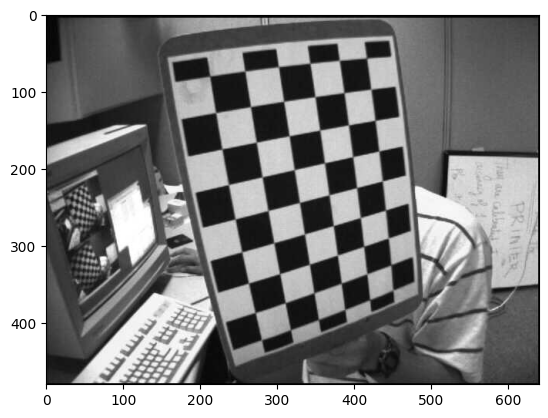

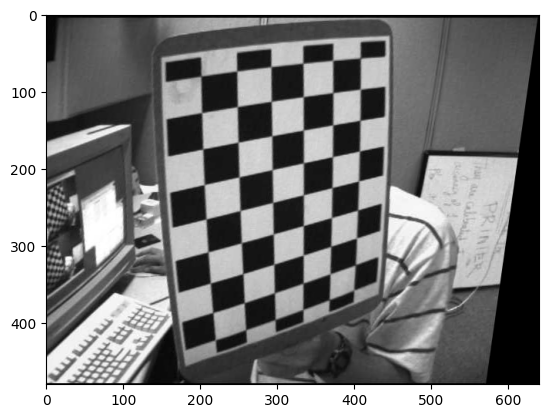

In [93]:
img = cv.imread('Chessboards/left14.jpg')
dst = cv.undistort(img, K,np.array([k[0],k[1],0,0,0]))
plt.imshow(img)
plt.figure(),plt.imshow(dst)

# Part V: comparison with openCV calibration result.

Now, we will use openCV calibration function to compare their results with our. The above cell enables to do so. Compare your calibration matrix, rotation and translation with the result. Conclusions ?

Remark: to obtain the rotation matrices, you can use cv.Rodrigues(rvecs[k])[0]

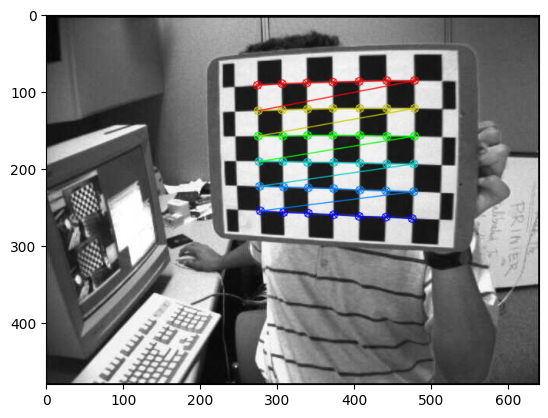

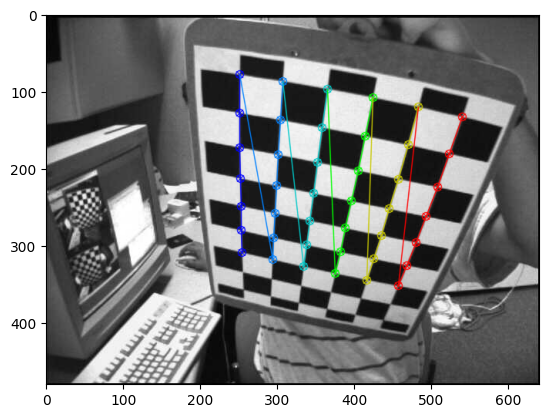

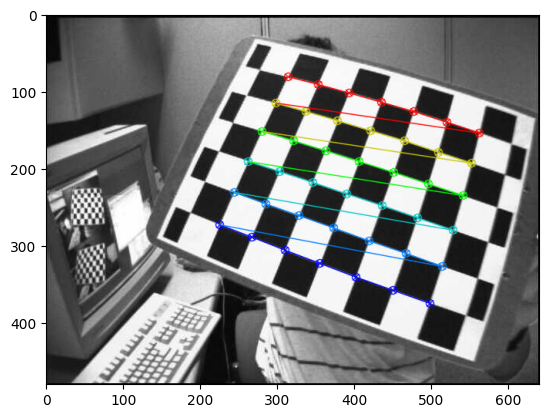

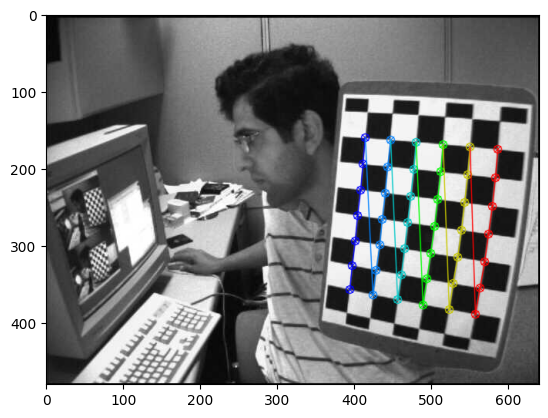

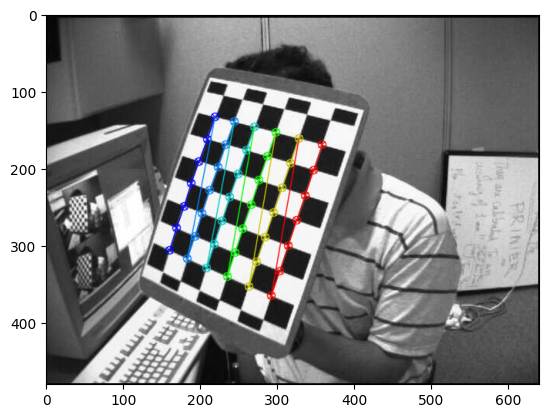

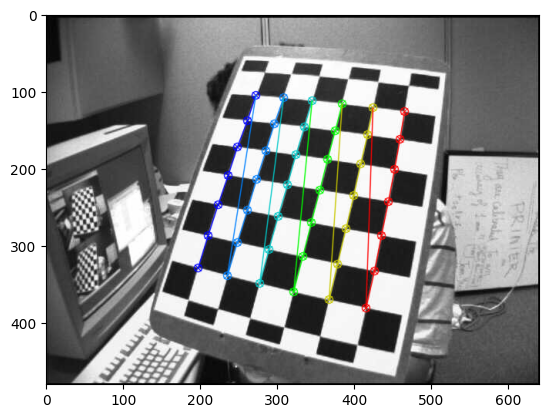

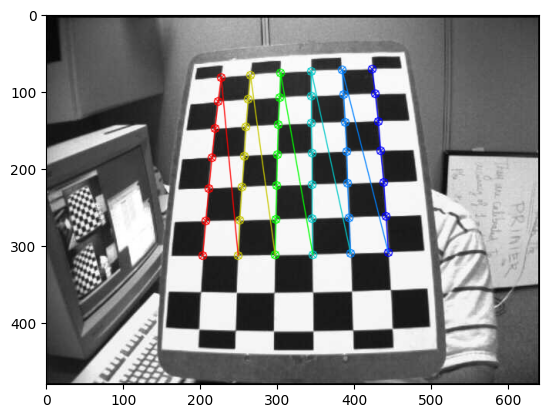

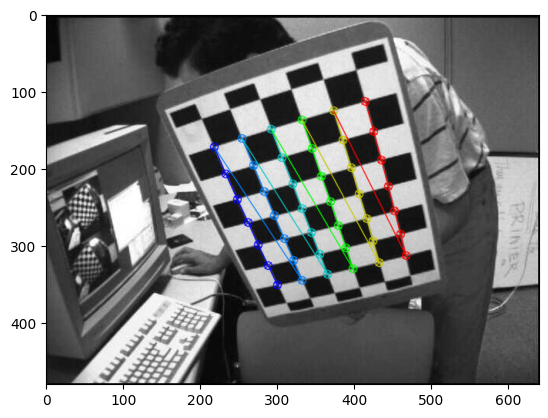

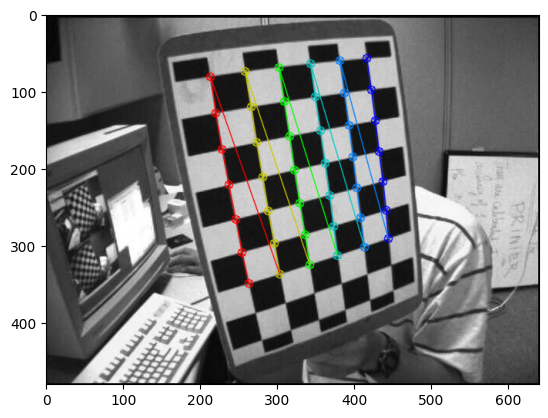

In [94]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space. List (length = nb of images) of np.array, each of size = 3 (corresponding to the 3D Euclidiean coordinates - the last coordinate is always chosen to be 0)
imgpoints = [] # 2d points in image plane. List (length = nb of images) of np.array, each of size = 2 (corresponding to the 2D Euclidiean coordinates - the coordinates might not be integers)
images = glob.glob('Chessboards/*.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (7,6), corners2, ret)
        plt.imshow(img)
        plt.show()

**Answer:** The results are definitely different. But the intrinsic matrix is up to a scale factor which could explain the difference. Still the results look similar when we plot the undistorted images.

In [95]:
ret, K_CV, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [96]:
print("Rotation Matrix (OpenCV):")
print(cv.Rodrigues(rvecs[0])[0])
print("\nRotation Matrix (Custom):")
print(extrinsic_matrices[0][:, :3])

print("\nTranslation Vector (OpenCV):")
print(tvecs[0])
print("\nTranslation Vector (Custom):")
print(extrinsic_matrices[0][:, 3])

print("\nIntrinsic Matrix (OpenCV):")
print(K_CV)
print("\nIntrinsic Matrix (Custom):")
print(K)

Rotation Matrix (OpenCV):
[[-0.96190534 -0.0100655   0.27319738]
 [-0.03466286 -0.98676627 -0.1584008 ]
 [ 0.27117634 -0.16183638  0.94882684]]

Rotation Matrix (Custom):
[[ 1.42055167e-01  9.89858742e-01 -1.90656098e-05]
 [ 9.89858742e-01 -1.42055167e-01  8.62583468e-06]
 [ 5.82998949e-06 -2.00976049e-05 -1.00000000e+00]]

Translation Vector (OpenCV):
[[ 3.79289445]
 [ 0.92423107]
 [14.8637219 ]]

Translation Vector (Custom):
[-1.28255848e+01 -7.15991402e+00 -9.45071462e-04]

Intrinsic Matrix (OpenCV):
[[534.15663137   0.         341.71479627]
 [  0.         534.25492559 232.05013999]
 [  0.           0.           1.        ]]

Intrinsic Matrix (Custom):
[[ 3.78827983e-02 -4.95804791e-03 -8.37744019e-04]
 [ 0.00000000e+00  3.49455146e-02 -2.23953565e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In the following cell, the original image and its distorted version using openCV estimation is plotted. Compare with your results. What could explain the differences? You can also use the last cell to compute the projection error.

**Answer:** The differences between the original and distorted images can be attributed to the different calibration methods used. Notice that opencv do not introduce the $s$ parameter in the Intrinsic Matrix but we did found one with our method and it can not be considered small regarding the other parameters (factor 10). OpenCV also considers that $f_x$ and $f_y$ are the same and compute tangential distorsion (whereas we do not). Therefore our models are really different. Moreover OpenCV may use a more sophisticated optimization algorithm or a different distortion model, leading to variations in the results. Finally, comparing our error to opencv's error, we can see that our projection error is huge. It is most likely due to the enumerated reasons above.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x20ce9927550>)

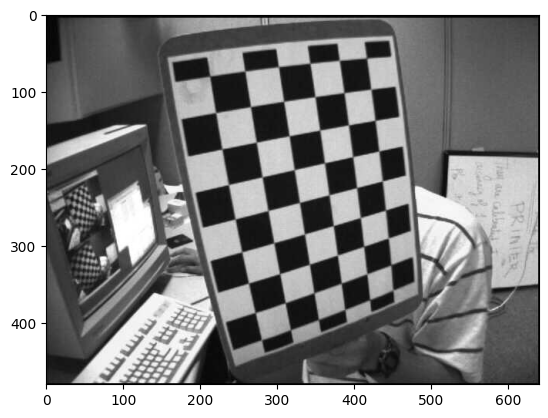

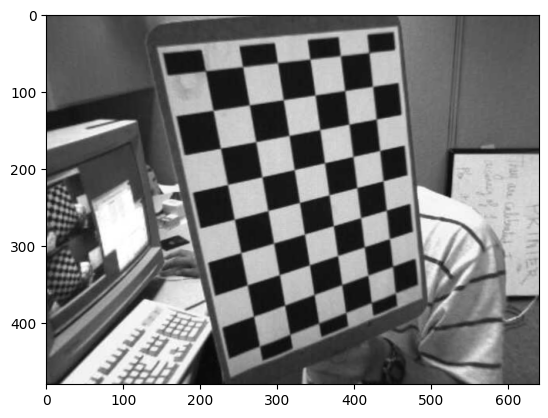

In [101]:
img = cv.imread('Chessboards/left14.jpg')
dst = cv.undistort(img, K_CV, dist, None, K_CV)
plt.imshow(img)
plt.figure(),plt.imshow(dst)

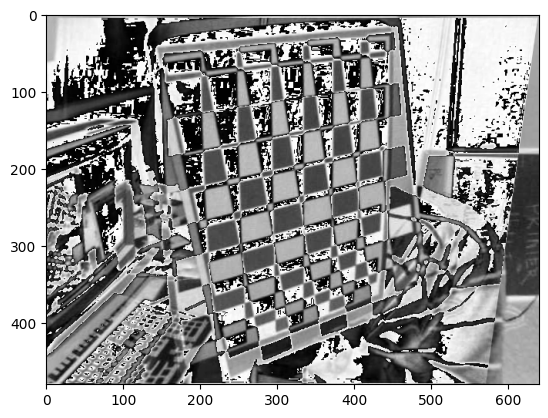

In [98]:
img = cv.imread('Chessboards/left14.jpg')

dist1 = cv.undistort(img, K,np.array([k[0],k[1],0,0,0]))
dist2 = cv.undistort(img, K_CV, dist, None, K_CV)

diff = np.abs(dist1 - dist2)
plt.imshow(diff)
plt.show()

In [108]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], K_CV, dist)

    # Assurez-vous que imgpoints[i] et imgpoints2[:, 0] ont le même format
    imgpoints1 = np.array(imgpoints[i], dtype=np.float32).reshape(-1, 2)
    imgpoints2 = imgpoints2[:, 0].reshape(-1, 2)

    error = cv.norm(imgpoints1, imgpoints2, cv.NORM_L2) / len(imgpoints2)
    mean_error += error

print("Total error with openCV: {}".format(mean_error / len(objpoints)))

Total error with openCV: 0.02369065671914049


In [109]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], extrinsic_matrices[i][:, :3], extrinsic_matrices[i][:,3], K, np.array([k[0],k[1],0,0,0]))

    # Assurez-vous que imgpoints[i] et imgpoints2[:, 0] ont le même format
    imgpoints1 = np.array(imgpoints[i], dtype=np.float32).reshape(-1, 2)
    imgpoints2 = imgpoints2[:, 0].reshape(-1, 2)

    error = cv.norm(imgpoints1, imgpoints2, cv.NORM_L2) / len(imgpoints2)
    mean_error += error

print("Total error with custom: {}".format(mean_error / len(objpoints)))

Total error with custom: 24.71174735749313
